# LSTM
Try LSTM(16) with Integer K-mers, Embedding, Mask Zero, and Return Sequences = False.

In [14]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-12 00:48:48.488736
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [15]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
#from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
EPOCHS=10
FOLDS=5  
BREAK = False   # break after first fold
MINLEN=1000
MAXLEN=4000   # this is problematic as some genes will be excluded entirely or partially

In [16]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [17]:
GENES_FILE =    'CNRCI_noncoding_train_genes.csv'
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_noncoding_train_counts.K4.gc42.csv'

In [18]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [19]:
print(datetime.now())
# labels
filepath = DATA_DIR+RCI_FILE
gene_to_rci = {}
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line = row.strip()
            fields = line.split(',')
            gene_id = fields[0]
            rci_val = fields[CELL_LINE_NUMBER+1]
            # Could implement Gudenas style threshold here
            if rci_val != "nan":
                gene_to_rci[gene_id] = float(rci_val)
print('Num RCI:', len(gene_to_rci.keys()))
print(list(gene_to_rci.items())[:3])
all_genes = list(gene_to_rci.keys())

2022-12-12 00:48:50.670815
Num RCI: 3327
[('ENSG00000099869', 1.0), ('ENSG00000116652', 1.65208), ('ENSG00000117242', -0.793877)]


In [20]:
def seq_to_kmers(rna,K):
    VALS = {'A':0, 'C':1, 'G':2, 'T':3}
    length = len(rna)
    vec=[]
    for i in range(length-K+1):
        value = 0
        for j in range(K):
            value *= 4   
            nextnuc = rna[i+j]
            if nextnuc=='N':
                value = -1   # indicate an N
                break
            nucval = VALS[nextnuc]
            value += nucval
        value += 1   # NNN => 0, AAA => 1
        vec.append(value)
    return vec
print(seq_to_kmers('AAAA',3))
print(seq_to_kmers('CATT',3))
print(seq_to_kmers('TTGA',3))
print(seq_to_kmers('TTTN',3))

[1, 1]
[20, 16]
[63, 57]
[64, 0]


In [21]:
print(datetime.now())
print('Load sequence')
filepath = DATA_DIR+SEQUENCE_FILE
labels=[]
allids=[]
allseq=[]
NREPEAT = str('N'*MAXLEN)
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line    = row.strip()
            fields  = line.split(',')
            tran_id = fields[0]  # with version number
            gene_id = fields[1]        # without version number
            seq_len = int(fields[3])
            seq_txt = fields[4]
            if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                rci_val = gene_to_rci[gene_id]
                allids.append( (gene_id,tran_id) )
                labels.append(rci_val)
                if seq_len<MAXLEN:
                    seq_txt = seq_txt + NREPEAT
                    seq_txt = seq_txt[:MAXLEN]
                hot_vec = seq_to_kmers(seq_txt,K)
                allseq.append(hot_vec)
print(datetime.now())
print('Num IDs:',len(allids))
#print('Examples:',[allids[x] for x in [10, 20, 30, 40]] )
print('Num labels:',len(labels))
#print('Examples:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
#print('Example:',allseq[3])

2022-12-12 00:48:50.711685
Load sequence
2022-12-12 00:49:14.025300
Num IDs: 8564
Num labels: 8564
Num counts: 8564


In [22]:
def get_gene_subset(all_genes,sub_index):
    sub_genes = set()
    for index in sub_index:
        one_gene = all_genes[index]
        sub_genes.add(one_gene)
    return sub_genes
def get_X_y(gene_set,allids,allX,allY,threshold):
    cnt = len(allids)
    subsetX=[]
    subsetY=[]
    if cnt != len(allX) or cnt!= len(allY):
        raise Exception('Lengths differ')
    for i in range(cnt):
        gene_id,tran_id = allids[i]
        if gene_id in gene_set:
            oneX = allX[i]
            oneY = allY[i]
            if oneY < threshold:
                Yvalue = int(0)
            else:
                Yvalue = int(1)
            subsetX.append(oneX)
            subsetY.append(Yvalue)
    subsetX = np.array(subsetX)
    subsetY = np.array(subsetY).reshape((-1,1))
    return subsetX,subsetY

In [23]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    EMBED_DIMEN = 16 # arbitrary hyperparameter
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    # To do: try with and without masking layer
    # To do: try the embedding layer with mask, instead of masking layer
    #mask_layer = Masking(mask_value=0, input_shape=(ADJUST_LENGTH, K))
    #mask_layer = Masking(mask_value=0, input_shape=(ADJUST_LENGTH, 1))
    # This layer automatically converts inputs to one-hot using alphabet size.
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    # rnn1_layer = LSTM(16, return_sequences=True, input_shape=[MAXLEN,DIMEN]) 
    rnn1_layer = LSTM(16, return_sequences=False) # True)
    # rnn1_layer = Bidirectional( LSTM(32, return_sequences=True) )
    # rnn1_layer = LSTM(16, return_sequences=True) 
    # rnn2_layer = LSTM(16, return_sequences=True)
    # Dense can handle sequence input. Is it the best thing to do?
    # dense1_layer = Dense(16,activation='sigmoid',dtype=dt)
    # dropout1_layer = Dropout(0.50)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    #rnn.add(mask_layer)
    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    #rnn.add(rnn2_layer)
    #rnn.add(dense1_layer)
    #rnn.add(dropout1_layer)
    #rnn.add(dense2_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [24]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-12 00:49:14.065503
COMPILE
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 3997, 16)          4112      
                                                                 
 lstm_6 (LSTM)               (None, 16)                2112      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,241
Trainable params: 6,241
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
def do_cross_validation(eps):
    cv_scores = []
    fold=0
    print(datetime.now())
    print('splitting')
    # KFold shuffles once before making the partitions
    splitter = KFold(n_splits=FOLDS,shuffle=True,random_state=42)
    for train_index,valid_index in splitter.split(all_genes):
        fold += 1
        print('Fold',fold)
        train_genes = get_gene_subset(all_genes,train_index)
        valid_genes = get_gene_subset(all_genes,valid_index)
        X_train,y_train = get_X_y(train_genes,allids,allseq,labels,0)
        X_valid,y_valid = get_X_y(valid_genes,allids,allseq,labels,0)

        print('Training example')
        print(X_train[0])
        
        print('Train sizes',X_train.shape,y_train.shape)
        print('Valid sizes',X_valid.shape,y_valid.shape)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        print(datetime.now())
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        print("Compute valiation accuracy")
        print(datetime.now())
        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print(datetime.now())
        cv_scores.append(scores[1] * 100)
        
        if BREAK:
            break
        
    print()
    return cv_scores
print(datetime.now())

2022-12-12 00:49:14.926970


2022-12-12 00:49:14.949027
2022-12-12 00:49:14.949155
splitting
Fold 1
Training example
[ 57 228 143 ...   0   0   0]
Train sizes (6777, 3997) (6777, 1)
Valid sizes (1787, 3997) (1787, 1)
Train set ones/size 2754 / 6777
Valid set ones/size 765 / 1787
BUILD MODEL
COMPILE
FIT
2022-12-12 00:49:17.670871
Epoch 1/10
212/212 [==============================] - 28s 112ms/step - loss: 0.6679 - accuracy: 0.5997 - val_loss: 0.7121 - val_accuracy: 0.5825
Epoch 2/10
212/212 [==============================] - 23s 108ms/step - loss: 0.6346 - accuracy: 0.6389 - val_loss: 0.7490 - val_accuracy: 0.5881
Epoch 3/10
212/212 [==============================] - 24s 115ms/step - loss: 0.6208 - accuracy: 0.6634 - val_loss: 0.7406 - val_accuracy: 0.5439
Epoch 4/10
212/212 [==============================] - 23s 109ms/step - loss: 0.6085 - accuracy: 0.6684 - val_loss: 0.7536 - val_accuracy: 0.5792
Epoch 5/10
212/212 [==============================] - 23s 106ms/step - loss: 0.5959 - accuracy: 0.6887 - val_loss: 0.7

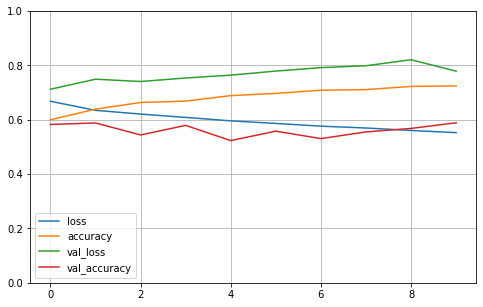

Compute valiation accuracy
2022-12-12 00:53:13.391348
accuracy: 58.87%
2022-12-12 00:53:15.787870
Fold 2
Training example
[121 228 142 ...   0   0   0]
Train sizes (6893, 3997) (6893, 1)
Valid sizes (1671, 3997) (1671, 1)
Train set ones/size 2899 / 6893
Valid set ones/size 620 / 1671
BUILD MODEL
COMPILE
FIT
2022-12-12 00:53:18.456180
Epoch 1/10
216/216 [==============================] - 27s 109ms/step - loss: 0.6699 - accuracy: 0.5934 - val_loss: 0.6511 - val_accuracy: 0.6254
Epoch 2/10
216/216 [==============================] - 22s 103ms/step - loss: 0.6310 - accuracy: 0.6453 - val_loss: 0.6733 - val_accuracy: 0.5619
Epoch 3/10
216/216 [==============================] - 23s 104ms/step - loss: 0.6111 - accuracy: 0.6628 - val_loss: 0.7070 - val_accuracy: 0.5254
Epoch 4/10
216/216 [==============================] - 23s 105ms/step - loss: 0.5997 - accuracy: 0.6778 - val_loss: 0.6924 - val_accuracy: 0.5661
Epoch 5/10
216/216 [==============================] - 23s 104ms/step - loss: 0.5861 

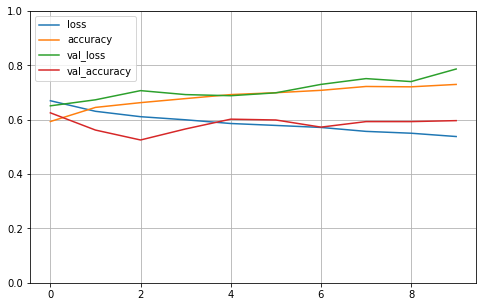

Compute valiation accuracy
2022-12-12 00:57:44.171183
accuracy: 59.66%
2022-12-12 00:57:46.570468
Fold 3
Training example
[121 228 142 ...   0   0   0]
Train sizes (7029, 3997) (7029, 1)
Valid sizes (1535, 3997) (1535, 1)
Train set ones/size 2994 / 7029
Valid set ones/size 525 / 1535
BUILD MODEL
COMPILE
FIT
2022-12-12 00:57:49.265880
Epoch 1/10
220/220 [==============================] - 27s 107ms/step - loss: 0.6671 - accuracy: 0.5898 - val_loss: 0.6586 - val_accuracy: 0.6248
Epoch 2/10
220/220 [==============================] - 24s 107ms/step - loss: 0.6346 - accuracy: 0.6372 - val_loss: 0.6573 - val_accuracy: 0.6300
Epoch 3/10
220/220 [==============================] - 23s 105ms/step - loss: 0.6209 - accuracy: 0.6506 - val_loss: 0.6803 - val_accuracy: 0.5557
Epoch 4/10
220/220 [==============================] - 23s 105ms/step - loss: 0.6087 - accuracy: 0.6644 - val_loss: 0.6690 - val_accuracy: 0.6091
Epoch 5/10
220/220 [==============================] - 23s 104ms/step - loss: 0.5984 

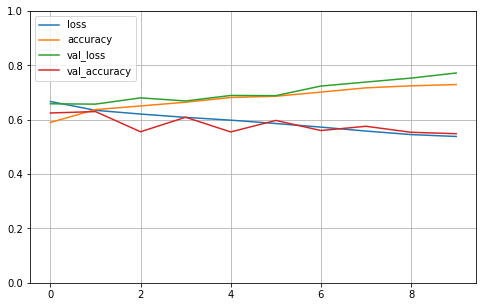

Compute valiation accuracy
2022-12-12 01:02:14.545144
accuracy: 54.85%
2022-12-12 01:02:16.725664
Fold 4
Training example
[121 228 142 ...   0   0   0]
Train sizes (6732, 3997) (6732, 1)
Valid sizes (1832, 3997) (1832, 1)
Train set ones/size 2666 / 6732
Valid set ones/size 853 / 1832
BUILD MODEL
COMPILE
FIT
2022-12-12 01:02:19.364516
Epoch 1/10
211/211 [==============================] - 28s 114ms/step - loss: 0.6590 - accuracy: 0.6120 - val_loss: 0.6997 - val_accuracy: 0.5524
Epoch 2/10
211/211 [==============================] - 22s 105ms/step - loss: 0.6245 - accuracy: 0.6502 - val_loss: 0.7022 - val_accuracy: 0.5622
Epoch 3/10
211/211 [==============================] - 22s 105ms/step - loss: 0.6124 - accuracy: 0.6676 - val_loss: 0.7029 - val_accuracy: 0.5655
Epoch 4/10
211/211 [==============================] - 22s 105ms/step - loss: 0.6052 - accuracy: 0.6726 - val_loss: 0.7091 - val_accuracy: 0.5579
Epoch 5/10
211/211 [==============================] - 23s 111ms/step - loss: 0.5967 

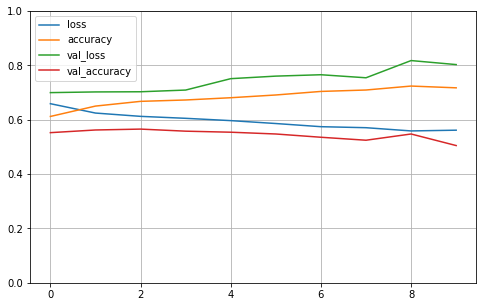

Compute valiation accuracy
2022-12-12 01:06:09.940817
accuracy: 50.49%
2022-12-12 01:06:12.429956
Fold 5
Training example
[121 228 142 ...   0   0   0]
Train sizes (6825, 3997) (6825, 1)
Valid sizes (1739, 3997) (1739, 1)
Train set ones/size 2763 / 6825
Valid set ones/size 756 / 1739
BUILD MODEL
COMPILE
FIT
2022-12-12 01:06:15.058457
Epoch 1/10
214/214 [==============================] - 28s 111ms/step - loss: 0.6605 - accuracy: 0.6070 - val_loss: 0.6933 - val_accuracy: 0.5371
Epoch 2/10
214/214 [==============================] - 23s 109ms/step - loss: 0.6262 - accuracy: 0.6503 - val_loss: 0.7149 - val_accuracy: 0.5538
Epoch 3/10
214/214 [==============================] - 22s 104ms/step - loss: 0.6045 - accuracy: 0.6803 - val_loss: 0.7463 - val_accuracy: 0.5319
Epoch 4/10
214/214 [==============================] - 23s 106ms/step - loss: 0.5908 - accuracy: 0.6973 - val_loss: 0.7687 - val_accuracy: 0.5089
Epoch 5/10
214/214 [==============================] - 22s 105ms/step - loss: 0.5810 

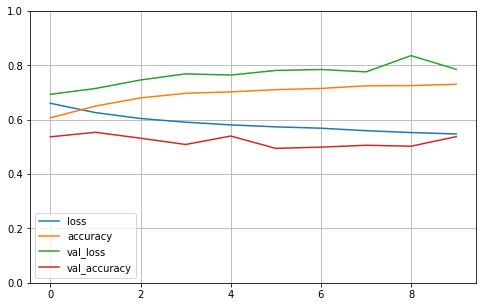

Compute valiation accuracy
2022-12-12 01:10:40.764935
accuracy: 53.77%
2022-12-12 01:10:43.214539

Cross validation acc mean 55.53% (+/- 3.38%)
2022-12-12 01:10:43.215905


In [26]:
print(datetime.now())
cv_scores = do_cross_validation(EPOCHS)    
print("Cross validation acc mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
print(datetime.now())